- Guzmán Pérez Karla Isela
- Velasco Avila Cristopher

# Ejercicio 4: Sistema de recomendación simple de películas
## Descripción:
Construye un sistema de recomendación usando un dataset de MovieLens de películas
basado en similitudes entre usuarios o entre películas.

In [12]:
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import pyarrow

## Carga y exploración general de los datos


In [13]:
movies = pl.read_csv("movies.csv")
ratings = pl.read_csv("ratings.csv")

Comenzamos importando los dataset de las peliculas y las calificaciones de los usuarios para posteriormente unificarlos todos en una sola tabla.

In [14]:
# Mostrar tipos de datos de cada columna
print(movies.columns)
print(ratings.columns)

['movieId', 'title', 'genres']
['userId', 'movieId', 'rating', 'timestamp']


In [15]:
# Cantidad de valores nulos por columna
print(movies.null_count())
print(ratings.null_count())

shape: (1, 3)
┌─────────┬───────┬────────┐
│ movieId ┆ title ┆ genres │
│ ---     ┆ ---   ┆ ---    │
│ u32     ┆ u32   ┆ u32    │
╞═════════╪═══════╪════════╡
│ 0       ┆ 0     ┆ 0      │
└─────────┴───────┴────────┘
shape: (1, 4)
┌────────┬─────────┬────────┬───────────┐
│ userId ┆ movieId ┆ rating ┆ timestamp │
│ ---    ┆ ---     ┆ ---    ┆ ---       │
│ u32    ┆ u32     ┆ u32    ┆ u32       │
╞════════╪═════════╪════════╪═══════════╡
│ 0      ┆ 0       ┆ 0      ┆ 0         │
└────────┴─────────┴────────┴───────────┘


Gracias al metodo null_count podemos ver que no hay valores nulos en el dataset, lo cual ayuda muchisimo para el analisis posterior.

In [16]:
print(movies.describe())
print(ratings.describe())

shape: (9, 4)
┌────────────┬──────────────┬─────────────────────────────────┬────────────────────┐
│ statistic  ┆ movieId      ┆ title                           ┆ genres             │
│ ---        ┆ ---          ┆ ---                             ┆ ---                │
│ str        ┆ f64          ┆ str                             ┆ str                │
╞════════════╪══════════════╪═════════════════════════════════╪════════════════════╡
│ count      ┆ 9742.0       ┆ 9742                            ┆ 9742               │
│ null_count ┆ 0.0          ┆ 0                               ┆ 0                  │
│ mean       ┆ 42200.353623 ┆ null                            ┆ null               │
│ std        ┆ 52160.494854 ┆ null                            ┆ null               │
│ min        ┆ 1.0          ┆ '71 (2014)                      ┆ (no genres listed) │
│ 25%        ┆ 3248.0       ┆ null                            ┆ null               │
│ 50%        ┆ 7301.0       ┆ null                 

No existen tantas incongruencias en los datos o columnas que debamos limpiar/eliminar.

## Limpieza básica.


Para comenzar con la organización de los datos, debemos armar una table que organice las calificaciones de los usuarios por cada pelicula. Sin embargo, hacer esto para absolutamente todas las peliculas y usuarios puede ser muy costoso en terminos de memoria, por lo que se recomienda hacer un muestreo de los datos. En este caso, tomaremos un muestreo de las peliculas que tengan al menos 20 reseñas, lo cual es suficiente para obtener una buena representacion de los datos y no consumir demasiada memoria.

In [17]:
conteo = ratings.group_by("movieId").agg(
    pl.len().alias("num_ratings")
)

peliculas_filtradas = conteo.filter(
    pl.col("num_ratings") >= 20
)

Observamos que la cantidad de peliculas ha sido reducida a 1297. Este numero se multiplica por la cantidad de usuarios que hayan calificado.

In [18]:
ratings_filtrados = ratings.join(
    peliculas_filtradas.select("movieId"), 
    on="movieId", 
    how="inner"
)

ratings_filtrados

userId,movieId,rating,timestamp
i64,i64,f64,i64
1,1,4.0,964982703
1,3,4.0,964981247
1,6,4.0,964982224
1,47,5.0,964983815
1,50,5.0,964982931
…,…,…,…
610,148626,4.0,1493847175
610,152081,4.0,1493846503
610,164179,5.0,1493845631


## Análisis exploratorio + visualización inicial y preprocesamiento técnico.

Realizamos un inner join entre los dataset de peliculas y calificaciones filtrados para obtener una tabla que contenga las calificaciones de los usuarios por cada pelicula.

In [19]:
matriz = ratings_filtrados.pivot(
    values="rating",
    index="userId",
    on="movieId"
)

matriz

userId,1,3,6,47,50,70,101,110,151,163,216,223,231,235,260,296,316,333,349,356,362,367,441,457,480,500,527,543,552,553,590,592,593,596,608,648,…,1292,2125,2340,2471,4015,4069,4388,4823,5444,7346,7454,8807,8910,45720,86833,94959,1172,1962,926,2010,39292,2384,6593,1091,3910,55269,1321,6283,2600,1958,7371,36401,5881,3979,4247,2986,2013
i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
1,4.0,4.0,4.0,5.0,5.0,3.0,5.0,4.0,5.0,5.0,5.0,3.0,5.0,4.0,5.0,3.0,3.0,5.0,4.0,4.0,5.0,4.0,4.0,5.0,4.0,3.0,5.0,4.0,4.0,5.0,4.0,4.0,4.0,5.0,5.0,3.0,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
2,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,4.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
3,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0.5,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
4,null,null,null,2.0,null,null,null,null,null,null,null,null,null,2.0,5.0,1.0,null,null,null,null,null,null,1.0,5.0,null,null,null,null,null,2.0,null,null,5.0,null,5.0,3.0,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
5,4.0,null,null,null,4.0,null,null,4.0,null,null,null,null,null,null,null,5.0,2.0,null,3.0,null,null,4.0,null,4.0,null,null,5.0,null,null,null,5.0,3.0,null,5.0,3.0,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
606,2.5,null,null,3.0,4.5,4.0,null,3.5,null,null,null,4.5,2.5,3.5,4.5,5.0,null,null,null,4.0,2.5,3.0,null,null,2.5,3.0,5.0,null,3.0,null,4.0,3.5,4.5,3.0,null,2.5,…,null,4.0,4.0,1.5,null,2.5,null,2.5,null,null,null,null,null,3.5,null,null,4.0,4.0,4.0,5.0,4.5,null,null,null,4.0,null,null,null,null,4.0,4.5,null,3.0,null,null,null,null
607,4.0,null,null,null,null,null,null,5.0,null,null,null,null,null,null,3.0,3.0,3.0,null,null,null,null,null,null,5.0,4.0,null,5.0,null,null,4.0,null,3.0,5.0,null,2.0,null,…,null,null,null,null,1.0,3.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
608,2.5,2.0,null,4.5,4.5,3.0,null,4.0,null,3.0,2.5,2.5,3.0,null,3.5,5.0,3.0,4.0,null,3.0,null,2.0,4.5,3.0,3.0,2.0,4.0,3.5,1.5,3.5,3.0,3.0,4.0,0.5,3.0,3.5,…,null,null,null,null,2.5,null,2.0,null,3.5,4.5,null,4.0,null,null,null,null,null,null,null,null,null,3.5,null,0.5,null,null,null,null,4.5,null,null,null,null,2.5,1.0,1.5,null


Con la instruccion anterior finalmente hemos desarrollado una tabla que contenga las calificaciones de usuarios por pelicula. La tabla contiene en el eje vertical a los usuarios y en el eje horizontal a las peliculas. Cada celda contiene la calificacion que el usuario le ha dado a la pelicula. Si un usuario no ha calificado una pelicula, la celda se queda vacia. Los valores vacios se cambian por cero en la siguiente celda.

In [20]:
matriz = matriz.fill_null(0)
matriz

userId,1,3,6,47,50,70,101,110,151,163,216,223,231,235,260,296,316,333,349,356,362,367,441,457,480,500,527,543,552,553,590,592,593,596,608,648,…,1292,2125,2340,2471,4015,4069,4388,4823,5444,7346,7454,8807,8910,45720,86833,94959,1172,1962,926,2010,39292,2384,6593,1091,3910,55269,1321,6283,2600,1958,7371,36401,5881,3979,4247,2986,2013
i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
1,4.0,4.0,4.0,5.0,5.0,3.0,5.0,4.0,5.0,5.0,5.0,3.0,5.0,4.0,5.0,3.0,3.0,5.0,4.0,4.0,5.0,4.0,4.0,5.0,4.0,3.0,5.0,4.0,4.0,5.0,4.0,4.0,4.0,5.0,5.0,3.0,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,5.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,5.0,0.0,5.0,3.0,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,0.0,0.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,2.0,0.0,3.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,5.0,0.0,0.0,0.0,5.0,3.0,0.0,5.0,3.0,0.0,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
606,2.5,0.0,0.0,3.0,4.5,4.0,0.0,3.5,0.0,0.0,0.0,4.5,2.5,3.5,4.5,5.0,0.0,0.0,0.0,4.0,2.5,3.0,0.0,0.0,2.5,3.0,5.0,0.0,3.0,0.0,4.0,3.5,4.5,3.0,0.0,2.5,…,0.0,4.0,4.0,1.5,0.0,2.5,0.0,2.5,0.0,0.0,0.0,0.0,0.0,3.5,0.0,0.0,4.0,4.0,4.0,5.0,4.5,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,4.0,4.5,0.0,3.0,0.0,0.0,0.0,0.0
607,4.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,4.0,0.0,5.0,0.0,0.0,4.0,0.0,3.0,5.0,0.0,2.0,0.0,…,0.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
608,2.5,2.0,0.0,4.5,4.5,3.0,0.0,4.0,0.0,3.0,2.5,2.5,3.0,0.0,3.5,5.0,3.0,4.0,0.0,3.0,0.0,2.0,4.5,3.0,3.0,2.0,4.0,3.5,1.5,3.5,3.0,3.0,4.0,0.5,3.0,3.5,…,0.0,0.0,0.0,0.0,2.5,0.0,2.0,0.0,3.5,4.5,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.5,0.0,0.5,0.0,0.0,0.0,0.0,4.5,0.0,0.0,0.0,0.0,2.5,1.0,1.5,0.0


Con esto hemos limpiado los valores con 0 y podemos proceder al analisis descriptivo. Eliminando asi todos los valores nulos y los posibles valores faltantes de cero

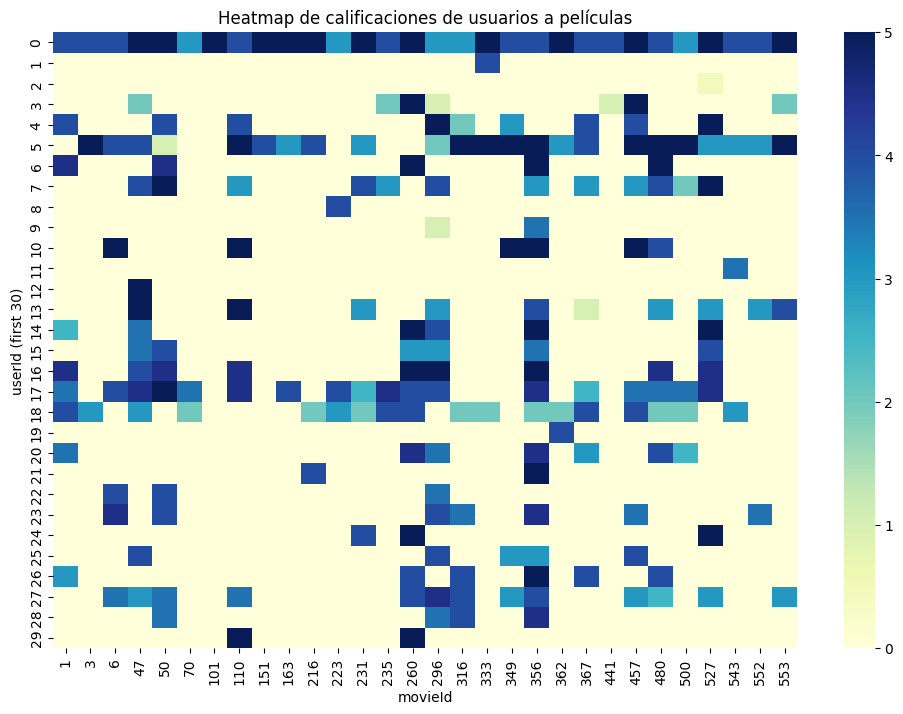

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

matriz_pd = matriz.to_pandas()

matriz_sample = matriz_pd.iloc[:30, 1:31]  # Exclude userId column for heatmap

plt.figure(figsize=(12, 8))
sns.heatmap(matriz_sample, cmap="YlGnBu", cbar=True)
plt.xlabel("movieId")
plt.ylabel("userId (first 30)")
plt.title("Heatmap de calificaciones de usuarios a películas")
plt.show()

Como ejemplo simple, podemos observar en el mapa de calor los usuarios y las peliculas que han sido calificados, los valores de las calificaciones se muestran desde 0 (amarillo claro) hasta 5 (azul oscuro). 

## Entrenamiento del modelo de ML

Para el entrenamiento del modelo, se ha usado KNN (K-Nearest Neighbors) para encontrar similitudes entre usuarios o películas. Este modelo es adecuado para sistemas de recomendación basados en similitudes, ya que puede identificar patrones en las calificaciones de los usuarios.

In [22]:
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [23]:
# Quitar columna userId y convertir la matriz a NumPy
X = matriz.select(pl.exclude("userId")).to_numpy()

# Guardar los movieIds en el orden en que están como columnas
movie_ids = matriz.select(pl.exclude("userId")).columns

# Crear modelo KNN
knn = NearestNeighbors(metric="cosine", algorithm="brute")
knn.fit(X.T)  # Transpuesta porque queremos similitud entre películas

,n_neighbors,5
,radius,1.0
,algorithm,'brute'
,leaf_size,30
,metric,'cosine'
,p,2
,metric_params,None
,n_jobs,None


Para el entrenamiento del modelo, se han excluido la columna de usuario, pues no aporta información relevante. En su lugar, el usuario se identifica por su índice en la tabla. El modelo se entrena con las calificaciones de los usuarios para cada película, y luego se puede usar para predecir calificaciones para películas no vistas por un usuario.

## Evaluación del modelo.


El siguiente algoritmo se usa para evaluar el modelo. Se indica un user_id y el modelo se encarga de analizar las peliculas que ha visto y recomienda una lista de peliculas.

In [24]:
user_id = 30  # cámbialo por cualquier ID válido

# Obtener fila del usuario
fila_usuario = matriz.filter(pl.col("userId") == user_id).select(pl.exclude("userId")).to_numpy()[0]

# Índices de películas con rating >= 4.0
peliculas_gustadas = np.where(fila_usuario >= 4.0)[0]

peliculas_gustadas

array([   7,   14,   58,   60,   63,   77,  131,  181,  187,  192,  194,
        198,  452,  463,  473,  490,  542,  555,  626,  627,  643,  645,
        648,  685,  699,  817, 1039, 1041, 1045, 1046, 1143])

In [25]:
# Para guardar resultados
recomendaciones = set()

for idx in peliculas_gustadas:
    distancias, indices = knn.kneighbors([X.T[idx]], n_neighbors=6)  # incluye la propia
    for i in indices[0]:
        if i != idx and fila_usuario[i] == 0.0:  # no la ha visto
            recomendaciones.add(i)

7. Visualización de resultados y métricas
Muestra los resultados y métricas con gráficos claros y explicativos.

In [26]:
# Índices → movieId
recomendadas = [int(movie_ids[i]) for i in recomendaciones]

# Unir con el CSV de películas para mostrar títulos
peliculas = pl.read_csv("movies.csv")
sugeridas = peliculas.filter(pl.col("movieId").is_in(recomendadas))

print(sugeridas)


shape: (51, 3)
┌─────────┬────────────────────────────┬─────────────────────────────────┐
│ movieId ┆ title                      ┆ genres                          │
│ ---     ┆ ---                        ┆ ---                             │
│ i64     ┆ str                        ┆ str                             │
╞═════════╪════════════════════════════╪═════════════════════════════════╡
│ 50      ┆ Usual Suspects, The (1995) ┆ Crime|Mystery|Thriller          │
│ 296     ┆ Pulp Fiction (1994)        ┆ Comedy|Crime|Drama|Thriller     │
│ 356     ┆ Forrest Gump (1994)        ┆ Comedy|Drama|Romance|War        │
│ 457     ┆ Fugitive, The (1993)       ┆ Thriller                        │
│ 480     ┆ Jurassic Park (1993)       ┆ Action|Adventure|Sci-Fi|Thrill… │
│ …       ┆ …                          ┆ …                               │
│ 122900  ┆ Ant-Man (2015)             ┆ Action|Adventure|Sci-Fi         │
│ 122922  ┆ Doctor Strange (2016)      ┆ Action|Adventure|Sci-Fi         │
│ 134130  